In [4]:
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob
import pandas as pd
import pyaudio
import sklearn
import librosa.display 
from praatio import tgio
import scipy # sub band energy ratio 
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

# Getting video and converting to audio 

run the following command in shell 

youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=btBZvsPCMQ0`

# Processing audio file 

In [5]:
path = **download clip1 from the repo and enter the reqd address**


# labelled data

In [6]:
# the audio file was labelled using Praat
tg = tgio.openTextgrid("./final_annotation.TextGrid")
entryList = tg.tierDict["clip1_annotate"].entryList

annotated_df = pd.DataFrame(entryList)
annotated_df['delta'] = annotated_df['end'] - annotated_df['start'] #the time spent for each segment.

In [7]:
y, sr = lr.load(path, sr=None)

/Users/avinashl/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# Group wise audio features  : mean ,variance , avg zero crossings , avg peaks

In [8]:
# Extract 2 sec audio segments from the main audio file

def extract_category(y,segments):
    audio_cat = []
    # compute segment regions in number of samples
    starts = np.floor(segments.start*44100).astype('int')
    ends = np.ceil(segments.end*44100).astype('int')

    # slice the audio into segments
    for i ,start, end in zip(range(len(annotated_df)),starts, ends):
        audio_seg = y[start:end]
        audio_cat.append(audio_seg)
        print('extracting audio segment:', len(audio_seg), 'samples')
    return audio_cat    

In [9]:

annotated_df.loc[annotated_df['label']=='arnab,introduction','label'] = 'speaker'
annotated_df.loc[annotated_df['label']=='mutiple','label'] = 'multiple'
list_other = ['noise','silence', 'trash','break', 'end_tune']
annotated_df.loc[annotated_df['label'].isin(list_other),'label'] = 'other'

speaker_df = annotated_df[annotated_df['label']=='speaker']
multiple_df = annotated_df[annotated_df['label']=='multiple']
other_df = annotated_df[annotated_df['label']=='other']

speaker_audio = np.concatenate(extract_category(y,speaker_df) ,axis =0)
multiple_audio = np.concatenate(extract_category(y,multiple_df),axis =0)
other_audio = np.concatenate(extract_category(y,other_df),axis =0)

extracting audio segment: 5763209 samples
extracting audio segment: 2890435 samples
extracting audio segment: 690087 samples
extracting audio segment: 2861830 samples
extracting audio segment: 196047 samples
extracting audio segment: 200758 samples
extracting audio segment: 199630 samples
extracting audio segment: 1295103 samples
extracting audio segment: 845660 samples
extracting audio segment: 105971 samples
extracting audio segment: 713907 samples
extracting audio segment: 926018 samples
extracting audio segment: 86544 samples
extracting audio segment: 40623 samples
extracting audio segment: 204878 samples
extracting audio segment: 138968 samples
extracting audio segment: 367365 samples
extracting audio segment: 1886764 samples
extracting audio segment: 2318643 samples
extracting audio segment: 39892 samples
extracting audio segment: 32136 samples
extracting audio segment: 34123 samples
extracting audio segment: 95653 samples
extracting audio segment: 450907 samples
extracting audio

extracting audio segment: 123045 samples
extracting audio segment: 128592 samples
extracting audio segment: 105972 samples
extracting audio segment: 37091 samples
extracting audio segment: 86543 samples
extracting audio segment: 56519 samples
extracting audio segment: 144827 samples
extracting audio segment: 90076 samples
extracting audio segment: 49454 samples
extracting audio segment: 54752 samples
extracting audio segment: 37091 samples
extracting audio segment: 51221 samples
extracting audio segment: 38785 samples
extracting audio segment: 35460 samples
extracting audio segment: 54298 samples
extracting audio segment: 22703 samples
extracting audio segment: 43880 samples
extracting audio segment: 23271 samples
extracting audio segment: 107487 samples
extracting audio segment: 55406 samples
extracting audio segment: 31028 samples
extracting audio segment: 50973 samples
extracting audio segment: 23682 samples
extracting audio segment: 60280 samples
extracting audio segment: 29065 sam

## mean over 1 second window 

In [10]:
LEN = 44100*2

def avg(data):
    mean_list = []
    for i in range((len(data) + LEN - 1) // LEN):
        sublist = data[i*LEN:(i+1)*LEN]
        mean = sum(sublist) / len(sublist)
        mean_list.append(mean)
    return mean_list

In [11]:
speaker_mean_list = avg(speaker_audio)
multiple_mean_list = avg(multiple_audio)


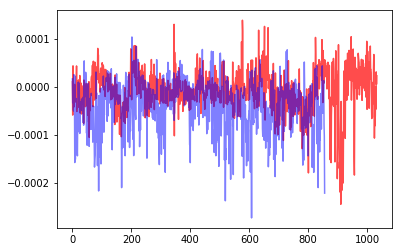

In [12]:
plt.plot(speaker_mean_list, 'r',alpha=0.7) # plotting t, a separately 
plt.plot(multiple_mean_list, 'b',alpha=0.5) # plotting t, b separately 
plt.show()

## Standard deviation over 1 sec window

In [13]:
LEN = 44100*2

def stdev(data):
    std_list = []
    for i in range((len(data) + LEN - 1) // LEN):
        sublist = data[i*LEN:(i+1)*LEN]
        std = np.std(sublist)**2
        std_list.append(std)
    return std_list

In [14]:
speaker_std_list = stdev(speaker_audio)
multiple_std_list = stdev(multiple_audio)


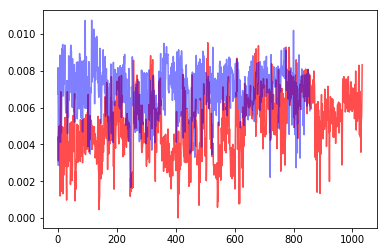

In [15]:
plt.plot(speaker_std_list, 'r',alpha=0.7) # plotting t, a separately 
plt.plot(multiple_std_list, 'b',alpha=0.5) # plotting t, b separately 
plt.show()

## number of peaks

In [16]:
LEN = 88200

def peak_find(data):

    count_arr = []
    mean_arr = []
    std_arr = []
        
    for i in range((len(data) + LEN - 1) // LEN):
        sublist = data[i*LEN:(i+1)*LEN]
        # calculating using all different peaks finding params
        prominence_temp = find_peaks(sublist, prominence=0.01)
        count_arr.append(len(prominence_temp[0]))
        mean_arr.append(prominence_temp[1]['prominences'].mean())
        std_arr.append(np.std(prominence_temp[1]['prominences']))
        
    return count_arr , mean_arr, std_arr

### Density of peaks 

In [17]:
speaker_peak_count, speaker_peak_mean , speaker_peak_std = peak_find(speaker_audio)
multiple_peak_count, multiple_peak_mean , multiple_peak_std = peak_find(multiple_audio)


## Sub band energy ratio 

In [18]:
LEN = 88200
def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = scipy.argmax(f > fmin) - 1
    ind_max = scipy.argmax(f > fmax) - 1
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max]) 

def sub_band_energy(data):
    energy_list = []
    
    for i in range((len(data) + LEN - 1) // LEN):
        sublist = data[i*LEN:(i+1)*LEN]
        energy = bandpower(sublist, LEN , 20,20000)
        energy_list.append(energy)
        
    return energy_list

/Users/avinashl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  after removing the cwd from sys.path.
/Users/avinashl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  """
/Users/avinashl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.trapz is deprecated and will be removed in SciPy 2.0.0, use numpy.trapz instead
  


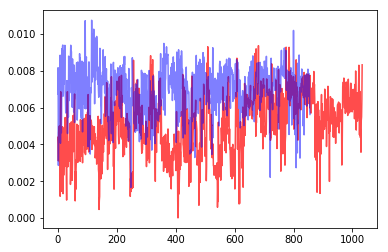

In [19]:

speaker_sub_band = sub_band_energy(speaker_audio)
multiple_sub_band = sub_band_energy(multiple_audio)


plt.plot(speaker_sub_band, 'r', alpha =0.7) # plotting t, a separately 
plt.plot(multiple_sub_band, 'b', alpha =0.5) # plotting t, b separately 
plt.show()


# Data Frames 

In [20]:
speaker_final_df = pd.DataFrame(speaker_mean_list , columns =['mean'])
multiple_final_df = pd.DataFrame(multiple_mean_list , columns =['mean'])

speaker_final_df['std'] = speaker_std_list
speaker_final_df['peak_density']=speaker_peak_count
speaker_final_df['peak_prominence_mean']=speaker_peak_mean
speaker_final_df['peak_prominence_std']=speaker_peak_std
speaker_final_df['sub_band_energy']=speaker_sub_band
speaker_final_df['category'] ='single'


multiple_final_df['std'] = multiple_std_list
multiple_final_df['peak_density']=multiple_peak_count
multiple_final_df['peak_prominence_mean']=multiple_peak_mean
multiple_final_df['peak_prominence_std']=multiple_peak_std
multiple_final_df['sub_band_energy']=multiple_sub_band
multiple_final_df['category'] ='multiple'








In [21]:
audio_df_final = speaker_final_df.append(multiple_final_df)

# Models

## SGD

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, recall_score,classification_report, balanced_accuracy_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV

In [24]:
X = audio_df_final.iloc[:,:-1]
y = audio_df_final.iloc[:,-1:]
scaler = StandardScaler()

# Splittin training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

# Scaled data must be used for classification tasks 
X_train_sc = scaler.fit_transform(X_train)
y_train_sc = y_train




In [25]:
## tuning 
tuned_parameters = {'loss':['hinge', 'log'],
                     'penalty' : ['l2', 'l1'],
                    'alpha' : np.arange(0.001,0.05,0.0001),
                    'learning_rate' : ['optimal','invscaling','adaptive'],
                    'max_iter' : np.arange(100,10000,500)
                                      }

clf = GridSearchCV(SGDClassifier(verbose = 1 ,n_jobs = -1, random_state = 99,eta0=0.0001)
, tuned_parameters, cv=5, scoring="accuracy" ,n_jobs = -1 , verbose = 2)

clf.fit(X_train_sc, y_train_sc.values.ravel())


Fitting 5 folds for each of 117600 candidates, totalling 588000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 4320 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 8848 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 14688 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 21808 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 30240 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 39952 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 50976 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 63280 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 76896 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 91792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 108000 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 125488 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 144

-- Epoch 1
Norm: 13.22, NNZs: 4, Bias: 0.124854, T: 1512, Avg. loss: 0.663124
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 13.47, NNZs: 4, Bias: 0.314351, T: 3024, Avg. loss: 0.527634
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 13.59, NNZs: 4, Bias: 0.179569, T: 4536, Avg. loss: 0.515333
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 13.66, NNZs: 4, Bias: 0.088515, T: 6048, Avg. loss: 0.510422
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 13.70, NNZs: 4, Bias: 0.079328, T: 7560, Avg. loss: 0.511399
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 13.73, NNZs: 4, Bias: 0.061436, T: 9072, Avg. loss: 0.507035
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 13.76, NNZs: 4, Bias: 0.186180, T: 10584, Avg. loss: 0.507347
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 13.79, NNZs: 4, Bias: 0.103636, T: 12096, Avg. loss: 0.506878
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 13.80, NNZs: 3, Bias: 0.138523, T: 13608, Avg. loss: 0.507859
Total training 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0001,
                                     fit_intercept=True, l1_ratio=0.15,
                                     learning_rate='optimal', loss='hinge',
                                     max_iter=1000, n_iter_no_change=5,
                                     n_jobs=-1, penalty='l2', power_t=0.5,
                                     random_state=99, shuffle=True, tol=0.001,
                                     validatio...
       0.049 , 0.0491, 0.0492, 0.0493, 0.0494, 0.0495, 0.0496, 0.0497,
       0.0498, 0.0499]),
                         'learning_rate': ['optimal', 'invscaling', 'adaptive'],
                         'loss': ['hinge', 'log'],
                         'max_iter': array([ 100,  600, 1100, 1600, 2100, 2600, 3100, 360

In [26]:
y_train_one_hot = y_train.replace('single',0)
y_train_one_hot = y_train_one_hot.replace('multiple',1)

y_test_one_hot = y_test.replace('single',0)
y_test_one_hot = y_test_one_hot.replace('multiple',1)

X_train_sc = scaler.fit_transform(X_train)
y_train_sc = y_train_one_hot

X_test_sc = scaler.fit_transform(X_test)

In [27]:
clf = SGDClassifier(verbose = 1 ,n_jobs = -1, random_state = 99,eta0=0.0001, alpha = 0.0086
                   ,learning_rate='optimal',loss='hinge',max_iter = 100, penalty = 'l1' )

clf.fit(X_train_sc, y_train_sc.values.ravel())

-- Epoch 1
Norm: 13.22, NNZs: 4, Bias: -0.124854, T: 1512, Avg. loss: 0.663124
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 13.47, NNZs: 4, Bias: -0.314351, T: 3024, Avg. loss: 0.527634
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 13.59, NNZs: 4, Bias: -0.179569, T: 4536, Avg. loss: 0.515333
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 13.66, NNZs: 4, Bias: -0.088515, T: 6048, Avg. loss: 0.510422
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 13.70, NNZs: 4, Bias: -0.079328, T: 7560, Avg. loss: 0.511399
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 13.73, NNZs: 4, Bias: -0.061436, T: 9072, Avg. loss: 0.507035
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 13.76, NNZs: 4, Bias: -0.186180, T: 10584, Avg. loss: 0.507347
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 13.79, NNZs: 4, Bias: -0.103636, T: 12096, Avg. loss: 0.506878
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 13.80, NNZs: 3, Bias: -0.138523, T: 13608, Avg. loss: 0.507859
Total 

SGDClassifier(alpha=0.0086, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
              loss='hinge', max_iter=100, n_iter_no_change=5, n_jobs=-1,
              penalty='l1', power_t=0.5, random_state=99, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=1, warm_start=False)

'alpha': 0.008600000000000003,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 100,
 'penalty': 'l1'

In [28]:
X_test_sc = scaler.fit_transform(X_test)
predictions = clf.predict(np.array(X_test_sc))
print(accuracy_score(y_test_one_hot, predictions))

0.7440633245382586


In [29]:
print(accuracy_score(y_test_one_hot, predictions))
print(classification_report(y_test_one_hot,predictions))

0.7440633245382586
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       209
           1       0.71      0.74      0.72       170

    accuracy                           0.74       379
   macro avg       0.74      0.74      0.74       379
weighted avg       0.75      0.74      0.74       379



## KNN 

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 2,weights ='distance')
knn_clf.fit(X_train_sc, y_train_sc.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')

In [32]:
## tuning 
tuned_parameters_knn = {'weights':['uniform', 'distance'],
                     'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                    'leaf_size' : np.arange(1,50,2),
                    'p' : np.arange(1,5,1)
                                      }

clf_knn = GridSearchCV(KNeighborsClassifier(n_neighbors = 2,metric_params= None)
, tuned_parameters_knn, cv=10, scoring="f1" ,n_jobs = -1 , verbose = 2)

clf_knn.fit(X_train_sc, y_train_sc.values.ravel())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2392 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 4656 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   25.2s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=2, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'p': array([1, 2, 3, 4]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [38]:
X_test_sc = scaler.fit_transform(X_test)
knn_predictions = knn_clf.predict(np.array(X_test_sc))
print(accuracy_score(y_test_one_hot, knn_predictions))

0.7229551451187335


In [39]:
knn_predictions = clf_knn.predict(np.array(X_test_sc))
print(accuracy_score(y_test_one_hot, knn_predictions))

0.7255936675461742


In [40]:
print(accuracy_score(y_test_one_hot, knn_predictions))
print(classification_report(y_test_one_hot,knn_predictions))

0.7255936675461742
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       209
           1       0.70      0.67      0.69       170

    accuracy                           0.73       379
   macro avg       0.72      0.72      0.72       379
weighted avg       0.72      0.73      0.72       379



## MLP 

In [41]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

mlp_clf.fit(X_train_sc, y_train_sc.values.ravel())


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [43]:
## tuning 
tuned_parameters_mlp = {'hidden_layer_sizes' : np.arange(10,510,100),
                        'activation' : ['identity','logistic','tanh','relu'],
                        'solver' : ['lbfgs', 'sgd', 'adam'],
                        'alpha' : np.arange(0.0001,0.001,0.00005) ,
                        'batch_size' : np.arange(10,200,10),
                      }

clf_mlp = RandomizedSearchCV(MLPClassifier(random_state = 99),n_iter = 500
, param_distributions = tuned_parameters_mlp, cv=5, scoring="accuracy" ,n_jobs = -1 , verbose = 2)

clf_mlp.fit(X_train_sc, y_train_sc.values.ravel())


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 15.5min finished
/Users/avinashl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rand...
       0.00045, 0.0005 , 0.00055, 0.0006 , 0.00065, 0.0007 , 0.00075,
       0.0008 , 0.00085, 0.0009 , 0.00095]),
                                        'batch_size': array([ 10,

clf_mlp.best_params_

{'solver': 'adam',
 'hidden_layer_sizes': 410,
 'batch_size': 70,
 'alpha': 0.00035000000000000005,
 'activation': 'relu'}

In [44]:
mlp_predictions = mlp_clf.predict(np.array(X_test_sc))
print(accuracy_score(y_test_one_hot, mlp_predictions))


0.783641160949868


In [45]:
print(accuracy_score(y_test_one_hot, mlp_predictions))
print(classification_report(y_test_one_hot,mlp_predictions))

0.783641160949868
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       209
           1       0.77      0.74      0.75       170

    accuracy                           0.78       379
   macro avg       0.78      0.78      0.78       379
weighted avg       0.78      0.78      0.78       379



## XGBoost

In [46]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


clf = XGBClassifier(eval_metric ='error', early_stopping_rounds = 10, booster = 'gbtree',objective ="multi:softmax",num_class=2 )

param_grid = {
        'silent': [False],
        'max_depth':[int(x) for x in np.linspace(20, 400, num = 10)],
        'learning_rate': [0.001,0.005, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.3,0.4,0.5],
        'colsample_bytree': [ 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [ 0.7, 0.8, 0.9, 1.0],
        'gamma': [0.005,0.01,0.02,0.05, 0.1,0.25,0.5,1,2,3,5],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0,150,200,300],
        'n_estimators': np.arange(50,1060,100),
        'alpha' :np.arange(0.0001,0.001,0.00005)
        }


rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=500,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='accuracy', refit=True, random_state=42)

print("Randomized search..")
rs_clf.fit(X_train_sc, y_train_sc.values.ravel())

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Randomized search..
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.8min finished


Best score: 0.8194444444444444
Best params: 
alpha: 0.0009500000000000002
colsample_bylevel: 0.9
colsample_bytree: 0.8
gamma: 0.05
learning_rate: 0.1
max_depth: 188
n_estimators: 550
reg_lambda: 50.0
silent: False
subsample: 0.3


In [47]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


clf = XGBClassifier(eval_metric ='error', early_stopping_rounds = 10, booster = 'gbtree',objective ="multi:softmax",num_class=2 )

param_grid = {
        'silent': [False],
        'max_depth':[int(x) for x in np.linspace(20, 400, num = 10)],
        'learning_rate': [0.001,0.005, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.3,0.4,0.5],
        'colsample_bytree': [ 0.3,0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [ 0.3,0.7, 0.8, 0.9, 1.0],
        'gamma': [0.005,0.01,0.02,0.05],
        'reg_lambda': [10.0, 50.0, 100.0,150,200,300],
        'n_estimators': np.arange(50,1060,100),
        'alpha' :np.arange(0.0001,0.001,0.00005)
        }


rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=500,
                            n_jobs=-1, verbose=2, cv=5,
                            scoring='f1', refit=True, random_state=42)

print("Randomized search..")
rs_clf.fit(X_train_sc, y_train_sc.values.ravel())

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  8.9min finished
/Users/avinashl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.800559834352089
Best params: 
alpha: 0.0008000000000000001
colsample_bylevel: 0.8
colsample_bytree: 0.8
gamma: 0.005
learning_rate: 0.005
max_depth: 400
n_estimators: 950
reg_lambda: 10.0
silent: False
subsample: 0.5


In [48]:
xgb_pred = rs_clf.predict(np.array(X_test_sc))
print(accuracy_score(y_test_one_hot, xgb_pred))

0.7783641160949868


In [49]:
print(accuracy_score(y_test_one_hot, xgb_pred))
print(classification_report(y_test_one_hot,xgb_pred))

0.7783641160949868
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       209
           1       0.76      0.74      0.75       170

    accuracy                           0.78       379
   macro avg       0.78      0.77      0.78       379
weighted avg       0.78      0.78      0.78       379



## Neural Nets

In [50]:
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense, Dropout,BatchNormalization,GlobalAveragePooling2D,BatchNormalization

from keras.optimizers import Adam


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
model = Sequential()

model.add(Dense(64,input_dim=6, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [51]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=150)
model = Sequential()
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.add(Dense(64,input_dim=6, activation='relu',kernel_initializer="he_normal",use_bias=False))
BatchNormalization()
model.add(Dense(128, activation='relu',kernel_initializer="he_normal",use_bias=False))
BatchNormalization()
model.add(Dense(128, activation='relu',kernel_initializer="he_normal",use_bias=False))
BatchNormalization()
model.add(Dense(128, activation='relu',kernel_initializer="he_normal",use_bias=False))
BatchNormalization()
model.add(Dense(64, activation='relu',kernel_initializer="he_normal",use_bias=False))
BatchNormalization()
model.add(Dense(1, activation='sigmoid'))


In [52]:
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_sc, y_train_sc.values.ravel(),epochs=50, batch_size=1, verbose=1,
         validation_data=(X_test_sc, y_test_one_hot), callbacks=[callback])

Epoch 1/50
1512/1512 [==============================] - 1s 951us/step - loss: 0.5128 - accuracy: 0.7712 - val_loss: 0.4893 - val_accuracy: 0.7704
Epoch 2/50
1512/1512 [==============================] - 1s 863us/step - loss: 0.4447 - accuracy: 0.8082 - val_loss: 0.5213 - val_accuracy: 0.7625
Epoch 3/50
1512/1512 [==============================] - 1s 856us/step - loss: 0.4392 - accuracy: 0.8022 - val_loss: 0.4922 - val_accuracy: 0.7836
Epoch 4/50
1512/1512 [==============================] - 1s 868us/step - loss: 0.4282 - accuracy: 0.8102 - val_loss: 0.4751 - val_accuracy: 0.7784
Epoch 5/50
1512/1512 [==============================] - 1s 871us/step - loss: 0.4243 - accuracy: 0.8168 - val_loss: 0.5267 - val_accuracy: 0.7784
Epoch 6/50
1512/1512 [==============================] - 1s 867us/step - loss: 0.4074 - accuracy: 0.8128 - val_loss: 0.5145 - val_accuracy: 0.7810
Epoch 7/50
1512/1512 [==============================] - 1s 907us/step - loss: 0.4066 - accuracy: 0.8214 - val_loss: 0.5680 -

In [77]:
model.history

In [53]:
y_pred = model.predict_classes(X_test_sc)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [54]:
print(accuracy_score(y_test_one_hot, y_pred))

0.7678100263852242


In [55]:
print(accuracy_score(y_test_one_hot, y_pred))
print(classification_report(y_test_one_hot,y_pred))

0.7678100263852242
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       209
           1       0.76      0.71      0.73       170

    accuracy                           0.77       379
   macro avg       0.77      0.76      0.76       379
weighted avg       0.77      0.77      0.77       379



# Summary pointers

Average speaking time label wise

In [ ]:
stats = annotated_df.groupby('label', as_index = False)['delta'].sum().sort_values('delta', ascending = False)
stats['pct'] = 100*stats['delta']/stats['delta'].sum()
print(stats)

Longest streak label wise

In [ ]:
longest_streak = annotated_df.groupby('label', as_index = False)['delta'].max().sort_values('delta', ascending = False)
print(longest_streak)

# only person to have 2 min streak is arnab 
# Get 6 seconds of silence 